In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler

In [37]:
df = pd.read_csv('https://raw.githubusercontent.com/hrbae/DRB_ML_Training/main/2022/week7/data/titanic.csv')
df

,survived,pclass,sex,age,sibsp,parch,fare,embarked,alone
0,0,3,male,22.0,1,0,7.2500,S,False
1,1,1,female,38.0,1,0,71.2833,C,False
2,1,3,female,26.0,0,0,7.9250,S,True
3,1,1,female,35.0,1,0,53.1000,S,False
4,0,3,male,35.0,0,0,8.0500,S,True
...,...,...,...,...,...,...,...,...,...
650,1,3,male,27.0,0,0,8.6625,S,True
651,0,1,male,38.0,0,0,0.0000,S,True
652,1,3,female,27.0,0,1,12.4750,S,False
653,0,3,male,2.0,4,1,39.6875,S,False


데이터 설명

In [38]:
df.dtypes

survived      int64
pclass        int64
sex          object
age         float64
sibsp         int64
parch         int64
fare        float64
embarked     object
alone          bool
dtype: object

In [39]:
df = df[['age', 'fare', 'survived']]

In [40]:
df = df.iloc[:100, :]

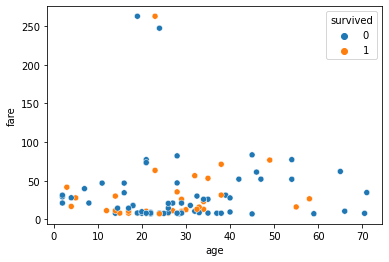

In [41]:
sns.scatterplot(x = df['age'], y = df['fare'], hue = df['survived'])

유클리드 거리 이해

In [42]:
df['S'] = 'not use'
df['S'][40] = 'Data 1'
df['S'][10] = 'Data 2'
df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,age,fare,survived,S
0,22.0,7.2500,0,not use
1,38.0,71.2833,1,not use
2,26.0,7.9250,1,not use
3,35.0,53.1000,1,not use
4,35.0,8.0500,0,not use
...,...,...,...,...
95,32.5,13.0000,1,not use
96,54.0,77.2875,0,not use
97,12.0,11.2417,1,not use
98,24.0,7.1417,1,not use


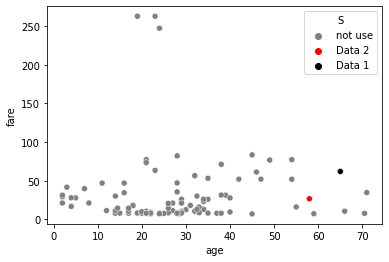

In [43]:
sns.scatterplot(x = df['age'], y = df['fare'], hue = df['S'], palette = ({'Data 1':'black', 'Data 2':'red', 'not use': 'gray'}))

빨간 점과 검정색 점의 거리는?

1. 빨간 점의 좌표부터 살펴보면

In [44]:
df.loc[df['S'] == 'Data 2', :][['age', 'fare']]

,age,fare
10,58.0,26.55


2. 검정색 점의 좌표를 살펴보면

이를 좌표에 저장해보면 다음과 같다.

In [45]:
x1 = df.loc[df['S'] == 'Data 2', :][['age', 'fare']].to_numpy()
x2 = df.loc[df['S'] == 'Data 1', :][['age', 'fare']].to_numpy()

In [46]:
print(x1.shape)
print(x2.shape)

(1, 2)
(1, 2)


In [47]:
x1 = x1.reshape(-1)
x2 = x2.reshape(-1)
print(x1.shape)
print(x2.shape)

(2,)
(2,)


In [48]:
print(x1)
print(x2)

[58.   26.55]
[65.     61.9792]


2차원 좌표공간에서 두 점 사이의 거리는 유클리드 거리로 알 수 있다.

In [49]:
def euclidean(dot1, dot2):
  return (((dot1[0]-dot2[0])**2) + ((dot1[1]-dot2[1])**2))**0.5

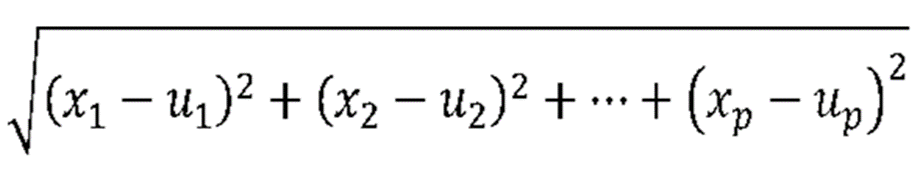

##해석

* **2란? 제곱
* **0.5란? 루트(0.5제곱)

* x1[0]: x1에서 첫번째 인덱스에 있는 숫자값
* x1[1]: x1에서 두번째 인덱스에 있는 숫자값
  * (인덱스는 0부터 시작하는것에 주의)

* (x1[0]-x2[0])**2) 부분: x1의 첫번째 값 58 - x2의 첫번째 값 65의 제곱
  * 유클리드 거리 계산식의 첫번째 항

* (x1[1]-x2[1])**2) 부분: x1의 두번째 값 26.55 - x2의 두번째 값 61.9792의 제곱

* 두 텀을 더한 뒤, 제곱하는 것: **0.5



In [50]:
euclidean(x1, x2)

36.11409991457629

라이브러리를 사용한다면 이렇게 구한 것과 같을까?

In [51]:
from scipy.spatial import distance

distance.euclidean(x1, x2)

36.11409991457629

#KNN 실습


## K가 매우 작은 경우: 과적합
* (지나치게 작은 영역까지 반영)
## K가 매우 큰 경우: 과소적합
* (지나치게 많은 영역을 포함)

라이브러리를 불러오지만, 모델을 만드는 것은 아님

In [52]:
knn = KNeighborsClassifier(n_neighbors = 3)

In [53]:
knn

KNeighborsClassifier(n_neighbors=3)

#실습
* 데이터 프레임에 적용해보기

In [54]:
#최소-최대 정규화 라이브러리 불러오기
scaler = MinMaxScaler()

In [55]:
df.iloc[:, :2] = scaler.fit_transform(df.iloc[:, :2])

In [56]:
df

,age,fare,survived,S
0,0.289855,0.001074,0,not use
1,0.521739,0.251180,1,not use
2,0.347826,0.003711,1,not use
3,0.478261,0.180158,1,not use
4,0.478261,0.004199,0,not use
...,...,...,...,...
95,0.442029,0.023533,1,not use
96,0.753623,0.274631,0,not use
97,0.144928,0.016665,1,not use
98,0.318841,0.000651,1,not use


In [57]:
train = df.iloc[:80, :].reset_index(drop=True)
test = df.iloc[80:, :].reset_index(drop=True)

In [58]:
train

,age,fare,survived,S
0,0.289855,0.001074,0,not use
1,0.521739,0.251180,1,not use
2,0.347826,0.003711,1,not use
3,0.478261,0.180158,1,not use
4,0.478261,0.004199,0,not use
...,...,...,...,...
75,0.463768,0.074309,0,not use
76,0.376812,0.003597,0,not use
77,0.275362,0.274631,0,not use
78,0.449275,0.006559,0,not use


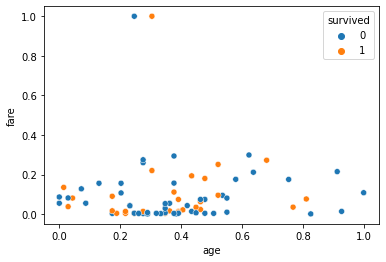

In [59]:
sns.scatterplot(x = train['age'], y = train['fare'], hue = train['survived'])

In [60]:
trainx = train[['age', 'fare']].to_numpy()
trainy = train['survived'].to_numpy()

testx = test[['age', 'fare']].to_numpy()
testy = test['survived'].to_numpy()

In [61]:
trainx

array([[2.89855072e-01, 1.07411386e-03],
       [5.21739130e-01, 2.51179768e-01],
       [3.47826087e-01, 3.71057514e-03],
       [4.78260870e-01, 1.80158188e-01],
       [4.78260870e-01, 4.19880871e-03],
       [7.53623188e-01, 1.75324675e-01],
       [0.00000000e+00, 5.50727468e-02],
       [3.62318841e-01, 1.62417733e-02],
       [1.73913043e-01, 9.02091593e-02],
       [2.89855072e-02, 3.79845718e-02],
       [8.11594203e-01, 7.64573772e-02],
       [2.60869565e-01, 4.19880871e-03],
       [5.36231884e-01, 9.49126062e-02],
       [1.73913043e-01, 3.43403964e-03],
       [7.68115942e-01, 3.52504638e-02],
       [0.00000000e+00, 8.65149888e-02],
       [4.20289855e-01, 4.30622010e-02],
       [4.78260870e-01, 7.43091495e-02],
       [4.63768116e-01, 2.35328581e-02],
       [1.88405797e-01, 4.11756664e-03],
       [3.76811594e-01, 1.11414901e-01],
       [8.69565217e-02, 5.50727468e-02],
       [5.21739130e-01, 9.53520164e-02],
       [2.46376812e-01, 1.00000000e+00],
       [5.507246

In [62]:
knn.fit(trainx, trainy)

KNeighborsClassifier(n_neighbors=3)

In [63]:
test

,age,fare,survived,S
0,0.376812,0.003597,0,not use
1,0.275362,0.002636,1,not use
2,0.521739,0.003597,0,not use
3,0.652174,0.175862,0,not use
4,0.181159,0.029213,0,not use
5,0.289855,0.004199,0,not use
6,0.260870,0.011132,0,not use
7,0.217391,0.029229,0,not use
8,0.275362,0.003711,0,not use
9,0.992754,0.003027,0,not use


In [64]:
test['Pred'] = knn.predict(testx)

In [65]:
test

,age,fare,survived,S,Pred
0,0.376812,0.003597,0,not use,0
1,0.275362,0.002636,1,not use,0
2,0.521739,0.003597,0,not use,0
3,0.652174,0.175862,0,not use,0
4,0.181159,0.029213,0,not use,1
5,0.289855,0.004199,0,not use,0
6,0.260870,0.011132,0,not use,0
7,0.217391,0.029229,0,not use,0
8,0.275362,0.003711,0,not use,0
9,0.992754,0.003027,0,not use,0


In [66]:
knn.score(testx, testy)

0.8

In [67]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test['survived'], test['Pred'])

array([[15,  1],
       [ 3,  1]])

In [68]:
#정확도
16/20

0.8

In [69]:
#민감도
15/16

0.9375

In [70]:
#정밀도
15/18

0.8333333333333334